In [16]:
###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/voice-data/Segmented'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
base_dir ='/kaggle/input/voice-data/Segmented'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/voice-data/Segmented/first_bank__first_bank_mmm.wav
/kaggle/input/voice-data/Segmented/08154825991__08154924991.wav
/kaggle/input/voice-data/Segmented/comrade_emma_wu_onye_naku.wav
/kaggle/input/voice-data/Segmented/ehen.wav
/kaggle/input/voice-data/Segmented/it_s_not_fair__it_s_not_fair.wav
/kaggle/input/voice-data/Segmented/otu_nime_ndi_nkea_metutara_kowakwara_nozugbo_ozugbo_ihe_nke_ahu_na_eme_otu_ugboala_chara_ha_oku_site_nazu_nke_bu_ugboala_ndi_oru_nchekwa_nke_ahu_mere_ka_onye_nya_keke_ahu_kwusi_ha_notu_ntabianya_ma_ch.wav
/kaggle/input/voice-data/Segmented/mgbede_oma_oo.wav
/kaggle/input/voice-data/Segmented/toledo_bu_onye_e_boro_ebubo_nruruaka_wuchara_nisi_obodo_ha_nke_bu_lima__a_mara_ya_ikpe_mkporo_mgbochi_onwa_iri_na_asato_zuru_ezu_wee_zigakwa_ya_nulo_mkporo_nke_di_na_babadilo_bu_eba_ya_na_ndi_aka_chib.wav
/kaggle/input/voice-data/Segmented/but.wav
/kaggle/input/voice-data/Segmented/it_s_not_fair.wav
/kaggle/input/voice-data/Segmented/i_gwokwa_nsi_i_gaghi_izu_ohi_

In [17]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=200, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=200):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


In [19]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [20]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


In [21]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=32,
        num_head=2,
        num_feed_forward=64,
        source_maxlen=200,
        target_maxlen=200,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


In [22]:
import re

def split_text_with_underscores(text):
    # Use regular expression to split the text at multiple underscores
    parts = re.split('_+', text)
    return parts


In [23]:
def get_data(maxlen=200):
    data = []
    for filepath in os.listdir(base_dir):
        sentence = filepath.rsplit('.', 1)[0]
#         print(len(sentence))
        if len(' '.join(split_text_with_underscores(sentence)))< maxlen:
            data.append({'audio':os.path.join(base_dir,filepath),'text':' '.join(split_text_with_underscores(sentence))})
    return data

In [24]:
import tensorflow_io as tfio

In [25]:
class VectorizeChar:
    def __init__(self, max_len=200):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


max_target_len = 200  # all transcripts in out data are < 200 characters
data = get_data(max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


import tensorflow as tf

def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]
    # padding to 10 seconds
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


split = int(len(data) * 0.99)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)
print(len(train_data))
print(len(ds))
print(len(val_ds))

vocab size 34
183
3
1


In [26]:
wer_list = []
precision = []
f1 = []
recall = []
def wer(reference, hypothesis):
    # Split the reference and hypothesis sentences into words
    ref_words = reference.split()
    hyp_words = hypothesis.split()

    # Initialize the matrix to store edit distances
    matrix = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))

    # Initialize the first row and column of the matrix
    for i in range(len(ref_words) + 1):
        matrix[i][0] = i
    for j in range(len(hyp_words) + 1):
        matrix[0][j] = j

    # Fill in the matrix using dynamic programming
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i - 1] == hyp_words[j - 1]:
                cost = 0
            else:
                cost = 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,          # Deletion
                matrix[i][j - 1] + 1,          # Insertion
                matrix[i - 1][j - 1] + cost   # Substitution
            )

    # The WER is the value in the bottom-right cell of the matrix
    wer_value = matrix[len(ref_words)][len(hyp_words)] / len(ref_words)

    return wer_value
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token
    def calculate_wer(self, reference, hypothesis):
        # Implement Word Error Rate (WER) calculation
        # You can use the existing 'wer' function from the previous response
        return wer(reference, hypothesis)

    def calculate_precision(self, reference, hypothesis):
        # Implement precision calculation
        reference_tokens = reference.split()
        hypothesis_tokens = hypothesis.split()
        common_tokens = set(reference_tokens) & set(hypothesis_tokens)
        precision = len(common_tokens) / len(hypothesis_tokens)
        return precision

    def calculate_accuracy(self, reference, hypothesis):
        # Implement accuracy calculation
        return np.mean(np.array(list(reference)) == np.array(list(hypothesis)))
    def calculate_recall(self, reference, hypothesis):
        # Implement recall calculation
        reference_tokens = reference.split()
        hypothesis_tokens = hypothesis.split()
        common_tokens = set(reference_tokens) & set(hypothesis_tokens)
        recall = len(common_tokens) / len(reference_tokens)
        return recall

    def calculate_f1_score(self, reference, hypothesis):
        # Implement F1 score calculation
        precision = self.calculate_precision(reference, hypothesis)
        recall = self.calculate_recall(reference, hypothesis)
        if precision + recall == 0:
            return 0.0
        f1_score = (2 * precision * recall) / (precision + recall)
        return f1_score

    def on_epoch_end(self, epoch, logs=None):
        
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
                
        wer_total = 0.0
        precision_total = 0.0
        recall_total = 0.0
        f1_score_total = 0.0
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")
            # Calculate metrics for the batch
            wer_total += self.calculate_wer(target_text, prediction)
            precision_total += self.calculate_precision(target_text, prediction)
            recall_total += self.calculate_recall(target_text, prediction)
            f1_score_total += self.calculate_f1_score(target_text, prediction)
            
        
        # Calculate average metrics for the entire batch
        avg_wer = wer_total / tf.cast(bs,dtype=tf.float32)
        avg_precision = precision_total / tf.cast(bs,dtype=tf.float32) 
        avg_recall = recall_total/tf.cast(bs,dtype=tf.float32)
        avg_f1 =  f1_score_total/tf.cast(bs,dtype=tf.float32)
        precision.append(avg_precision)
        wer_list.append(avg_wer)
        f1.append(avg_f1)
        recall.append(avg_recall)


In [27]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * tf.cast(epoch,dtype=tf.float32)
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (tf.cast(epoch,dtype=tf.float32) - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / self.decay_epochs,
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)


In [33]:
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=64,
    num_head=2,
    num_feed_forward=32,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=34
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
    )

# Define a callback for early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(
#    monitor='val_loss',
#    patience=10,  # Adjust patience as needed
#    restore_best_weights=True
#)
    
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn,metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb], epochs=300)

# Test the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/300
1/3 [=========>....................] - ETA: 44s - loss: 1.3284

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Bad format chunk size for WAV: Expected 16 or 18, but got40
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  Bad format chunk size for WAV: Expected 16 or 18, but got40
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_107382]

In [ ]:
history.history

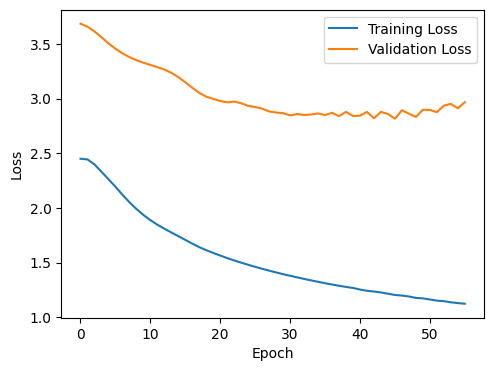

In [45]:
import matplotlib.pyplot as plt

# After training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(wer_list, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

plt.show()


In [50]:
epochs_list =[]
for i in range(1,81):
    epochs_list.append(i)


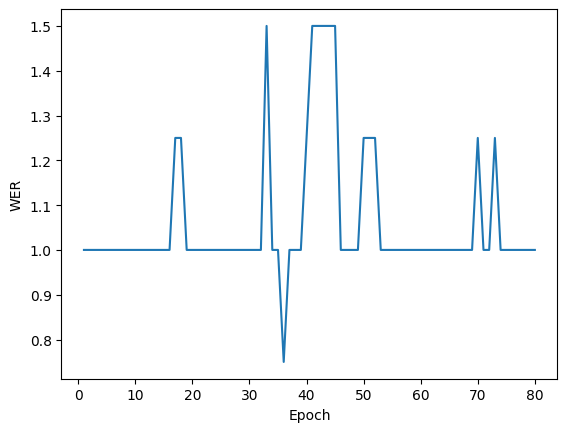

The average value for word error rate is 1.0593750476837158


In [51]:
# plotting the average WER for each epoch
plt.plot(epochs_list,wer_list)
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.show()
# print(len(wer_list))
average_wer = sum(wer_list)/len(wer_list)
print(f"The average value for word error rate is {average_wer.numpy()}")

ValueError: x and y must have same first dimension, but have shapes (80,) and (104,)

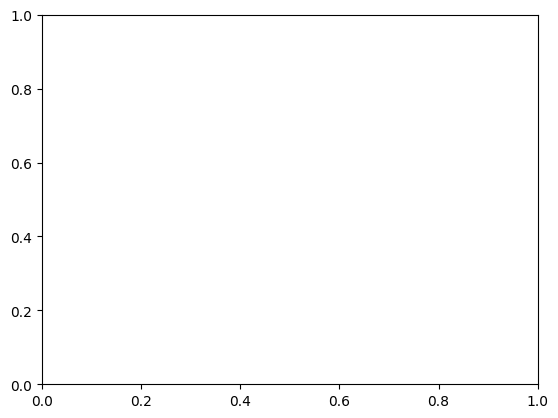

In [52]:
# plotting the average f1 for each epoch
plt.plot(epochs_list,f1)
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.show()
average_f1 = sum(f1)/len(f1)
print(f"The average value for F1 is {average_f1.numpy()}")

ValueError: x and y must have same first dimension, but have shapes (24,) and (48,)

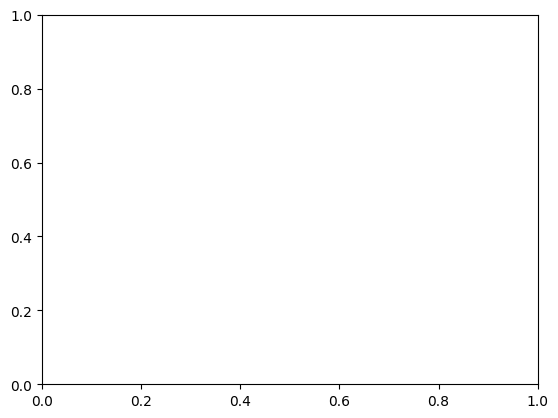

In [37]:
# plotting the average recall for each epoch
plt.plot(epochs_list,recall)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()
average_recall = sum(recall)/len(recall)
print(f"The average value for recall is {average_recall.numpy()}")

ValueError: x and y must have same first dimension, but have shapes (24,) and (48,)

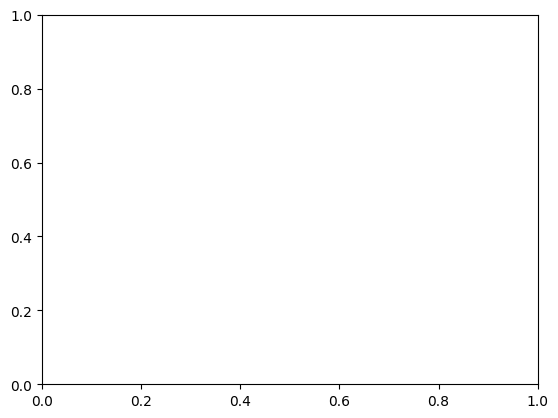

In [38]:
# plotting the average precision for each epoch
plt.plot(epochs_list,precision)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()
average_precision = sum(precision)/len(precision)
print(f"The average value for precison is {average_precision.numpy()}")